In [1]:
import torch
from pathlib import Path
import numpy as np
import u_net, data_setup, utils, engine
import nibabel as nib


c:\Users\graumnitz\AppData\Local\anaconda3\envs\heart\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
in_dir = Path.cwd()
target_dir = in_dir.parent / 'models'
target_dir.is_dir()

True

## 1. Load the metric data

In [3]:
train_loss = np.load(target_dir / 'train_loss.npy' )
train_metric = np.load(target_dir / 'train_metric.npy')
test_loss = np.load(target_dir / 'test_loss.npy')
test_metric = np.load(target_dir / 'test_metric.npy')

In [4]:
# Debug
(target_dir / 'train_loss.npy').is_file(),(target_dir / 'train_metric.npy').is_file(), (target_dir / 'test_loss.npy').is_file(), (target_dir / 'test_metric.npy').is_file()


(True, True, True, True)

## 2. Plot the metric data

<Figure size 640x480 with 0 Axes>

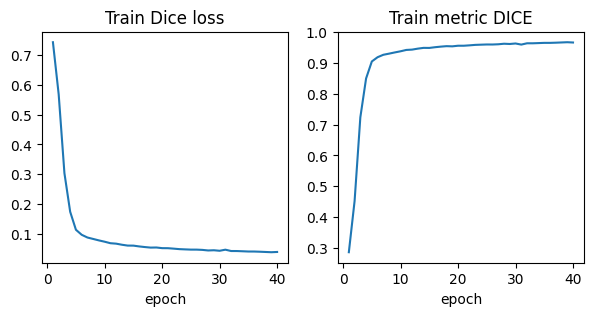

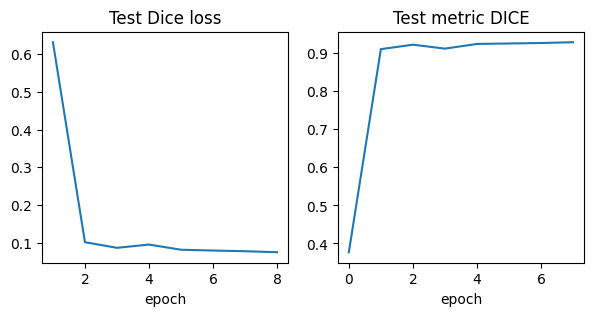

In [5]:
utils.plot_metric(train_loss = train_loss,
                  train_metric = train_metric,
                  test_loss = test_loss,
                  test_metric = test_metric)

### For visualization with TensorBoard, use "Tensorboard --logdir ..\runs" in the command line and open TensorBoard in your browser with "localhost:6007".

## 3. Plotting the prediction

### 3.1 Get the test data loader

In [3]:
_, test_dataloader = data_setup.prepare(in_dir = in_dir.parent / 'data')

c:\Users\graumnitz\AppData\Local\anaconda3\envs\heart\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


### 3.2 Loading a pretrained model

In [2]:
num_classes = utils.number_of_classes(in_dir = in_dir.parent / 'data' / 'train_segmentations')
model, device = u_net.unet()
model.load_state_dict(torch.load(target_dir / 'ModelV6_diceloss.pth'))
model.eval()

Layer (type (var_name))                                                               Input Shape               Output Shape              Param #                   Trainable
UNet (UNet)                                                                           [1, 1, 128, 128, 64]      [1, 8, 128, 128, 64]      --                        True
├─Sequential (model)                                                                  [1, 1, 128, 128, 64]      [1, 8, 128, 128, 64]      --                        True
│    └─ResidualUnit (0)                                                               [1, 1, 128, 128, 64]      [1, 16, 64, 64, 32]       --                        True
│    │    └─Conv3d (residual)                                                         [1, 1, 128, 128, 64]      [1, 16, 64, 64, 32]       448                       True
│    │    └─Sequential (conv)                                                         [1, 1, 128, 128, 64]      [1, 16, 64, 64, 32]       7,442       

NameError: name 'target_dir' is not defined

### 3.3 Get one dataset from the dataloader

In [6]:
test_patient = next(iter(test_dataloader))
    

### 3.4 Make a prediction with the dataset on the model

In [7]:
prediction, output = engine.perform_inference(model = model,
                                              test_patient = test_patient)

[INFO]
Image shape: torch.Size([1, 1, 128, 128, 64])
Label shape: torch.Size([1, 1, 128, 128, 64])
Binary segmentation shape: torch.Size([1, 8, 128, 128, 64])
Multi segmentation shape: torch.Size([1, 1, 128, 128, 64])


### 3.5 Plot the prediction with matplotlib

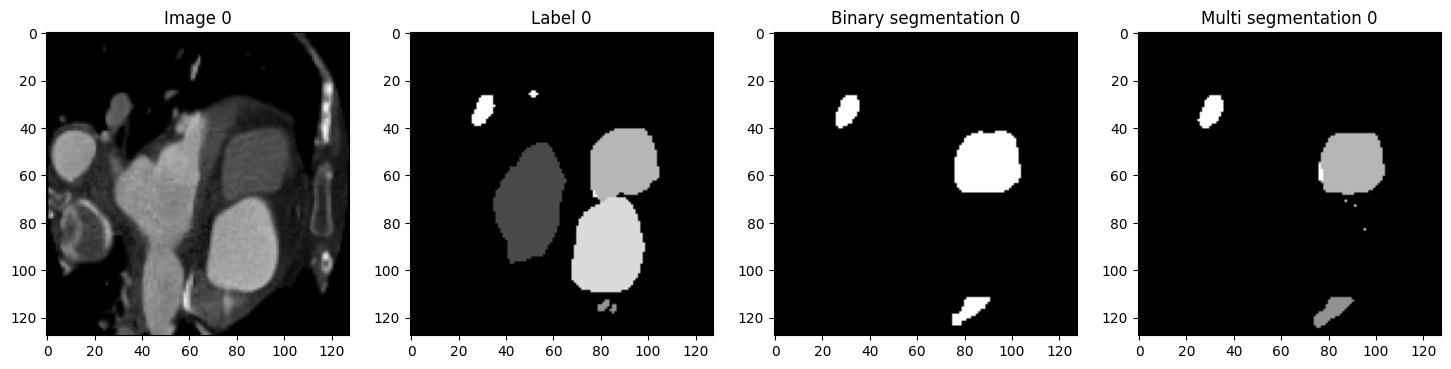

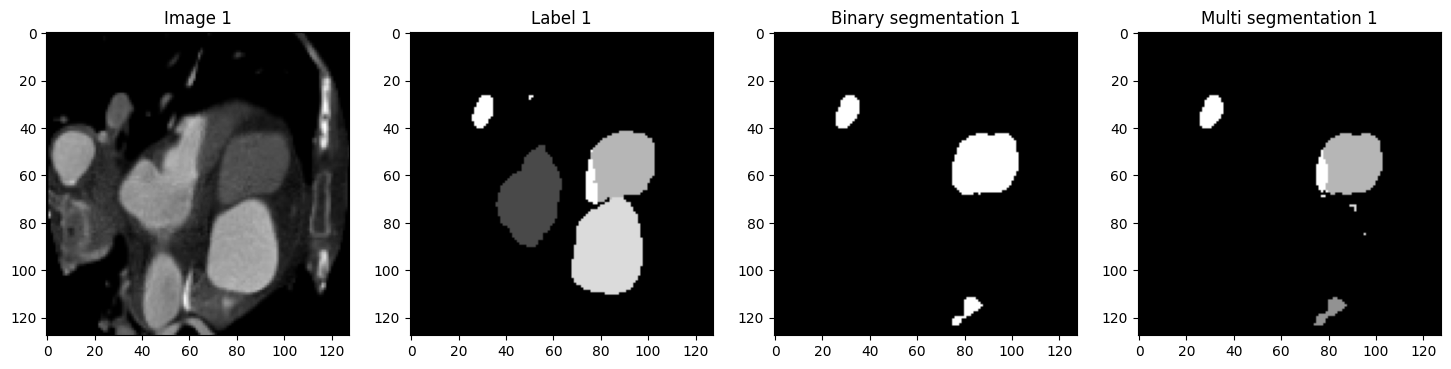

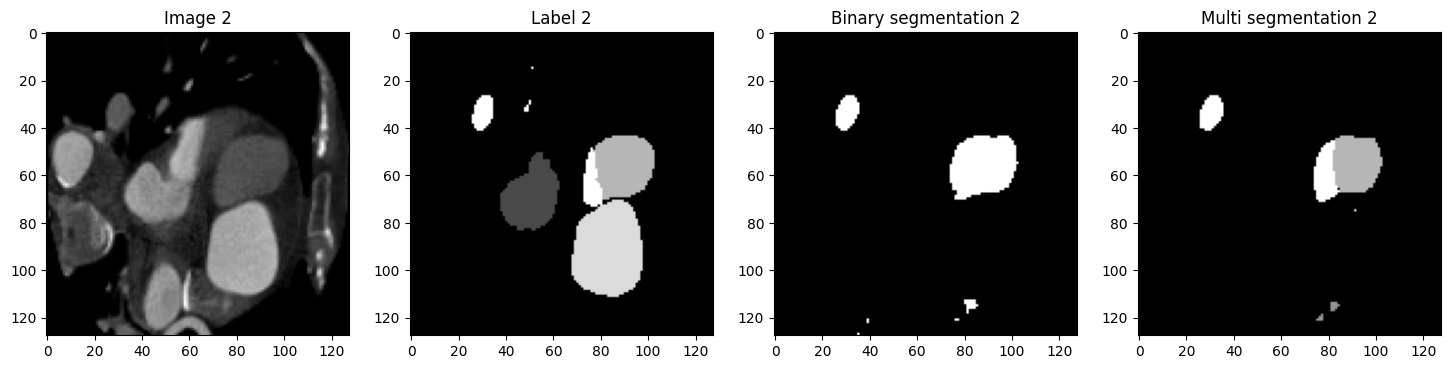

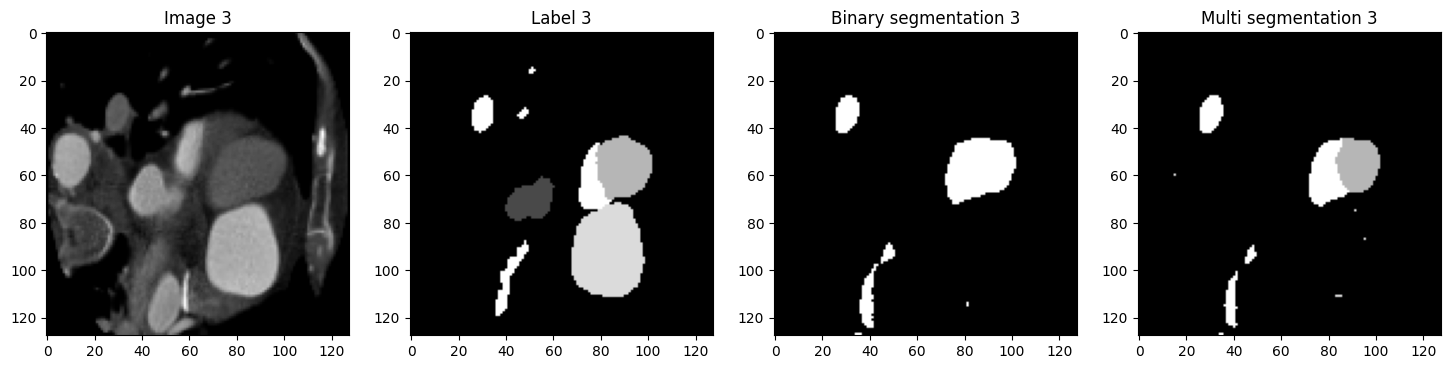

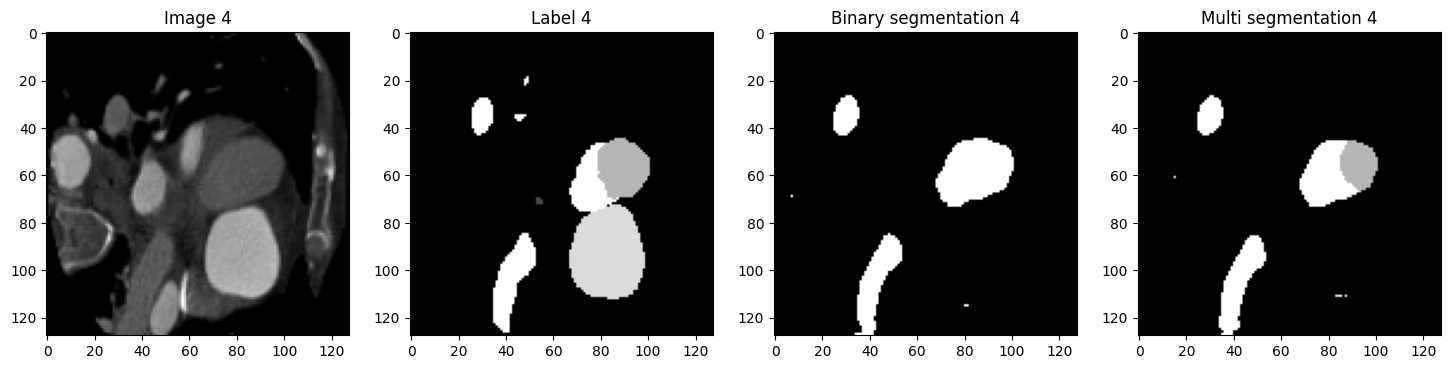

In [8]:
utils.plot_image_label_prediction(test_patient = test_patient,
                                  prediction = prediction,
                                  test_outputs = output)

## 4. Create a confusion matrix

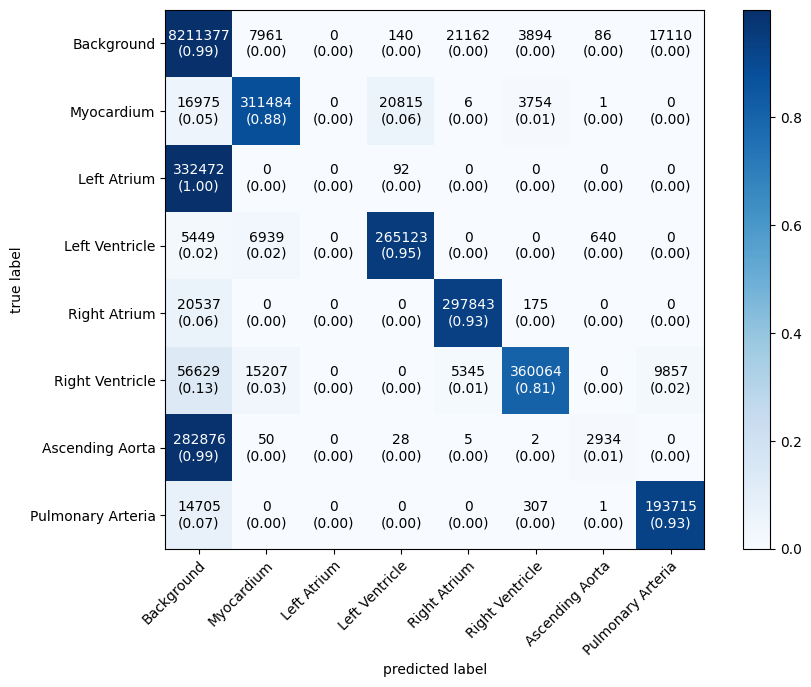

In [10]:
class_names = ['Background', 'Myocardium', 'Left Atrium', 'Left Ventricle', 'Right Atrium', 'Right Ventricle', 'Ascending Aorta', 'Pulmonary Arteria']

prediction_list = utils.plot_confusion_matrix(model = model,
                                              test_dataloader = test_dataloader,
                                              class_names = class_names)

## 5. Save the prediction as a nifti file

In [9]:
utils.save_nifti(prediction_list = prediction_list,
                  out_dir = Path.cwd().parent)

[INFO] Saving prediction_0 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_1 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_2 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_3 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_4 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_5 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_6 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_7 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_8 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_9 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation


In [31]:
target_size = (512, 512, 363)



# Interpolation durchführen
resized_prediction = torch.nn.functional.interpolate(
    prediction.unsqueeze(0).type(torch.float),  # Batch- und Kanal-Dimension hinzufügen
    size=target_size,
    mode='trilinear',  # Dreidimensionale Interpolation
    align_corners=False
)

# Die zusätzlichen Dimensionen wieder entfernen
resized_prediction = resized_prediction.squeeze(0).squeeze(0)

# Überprüfen der Größe
print(resized_prediction.shape)
nib.save(nib.Nifti1Image(resized_prediction.cpu().numpy().astype(float), affine = None), 'test2.nii.gz')

torch.Size([512, 512, 363])


In [27]:
prediction.shape

torch.Size([1, 128, 128, 64])